In [262]:
import sys
import umap
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import rfft, fftfreq
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, SpectralClustering, AffinityPropagation, OPTICS, Birch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.signal import find_peaks
mpl.rcParams['font.size'] = 12


name = 'a012_1'

file_path = 'C:/Users/micha/Downloads/train_dataset_1/' + name + '/data.hdf5'

Idea: When clustering we are looking to target relevant behaviour. If naive and applied to the whole data set, emergent groups would correspond to behaviour on the choosen time scale. For dt=0.05 this could be swinging the IMU left or right, or changing orientation. But as we are interested in behaviour on the seconds scale, like walking or sitting or talking on the phone, a relevant "time binning" must be applied. 

In [263]:
if '..' not in sys.path:
    sys.path.append('../')
from utils import load_data
data_dict = load_data(file_path, verbose=False)

size = data_dict['synced/gyro'].shape[0]
print(size)
N = size #Chopped to fit time bins
time_bin_size = 1500 #5 seconds pr behavior bin
num_bins = int(N/time_bin_size) #Giving 67 time bins

if N == 0:
    ekf_ori = data_dict['pose/ekf_ori']
    tango_ori = data_dict['pose/tango_ori']
    tango_pos = data_dict['pose/tango_pos']
    gyro = data_dict['synced/gyro']
    gyro_uncalib = data_dict['synced/gyro_uncalib']
    acc = data_dict['synced/acce']
    linacc = data_dict['synced/linacce']
    mag = data_dict['synced/magnet']
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time']
    rv = data_dict['synced/rv']
    game_rv = data_dict['synced/game_rv']
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]
    
else:
    ekf_ori = data_dict['pose/ekf_ori'][:N]
    tango_ori = data_dict['pose/tango_ori'][:N]
    tango_pos = data_dict['pose/tango_pos'][:N]
    gyro = data_dict['synced/gyro'][:N]
    gyro_uncalib = data_dict['synced/gyro_uncalib'][:N]
    acc = data_dict['synced/acce'][:N]
    linacc = data_dict['synced/linacce'][:N]
    mag = data_dict['synced/magnet'][:N]
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time'][:N]
    rv = data_dict['synced/rv'][:N]
    game_rv = data_dict['synced/game_rv'][:N]
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]

selected_features = np.concatenate([gyro.T, game_rv.T, rv.T, mag.T]).T #For now I only work with orientation and acceleration
#, gyro.T, linacc.T, game_rv.T, rv.T, mag.T
#Preparing the data
data_unprocessed = np.zeros((selected_features.shape[1], num_bins, time_bin_size))

for i in range(selected_features.shape[1]):
    for j in range(num_bins):
        data_unprocessed[i,j,:] = selected_features[j*time_bin_size : (j+1)*time_bin_size, i]


78031


Additionally a guiding hand in extracting the relevent features from the data should be applied. Characteristics of behaviour could be the average, the std and FFT of the orientation and acceration in the time bin.

In [264]:
#Computing the relevant features for the time bins
data_average = np.mean(data_unprocessed, axis=2)
data_std = np.std(data_unprocessed, axis=2)

#Standardizing the average and std
#scaler_average = StandardScaler()
#scaler_average.fit(data_average)
#scaled_data_average = scaler_average.transform(data_average)
#scaler_std = StandardScaler()
#scaler_std.fit(data_std)
#scaled_data_std = scaler_std.transform(data_average)

#Standardizing the time bins for FFT
data_signal = (data_unprocessed - data_average[:,:,None])/data_std[:,:,None]
data_fft = np.abs(rfft(data_signal, axis=2))

"""
# Get the frequency axis
frequency_axis = np.fft.rfftfreq(data_signal.shape[2])

# Find the peaks in the frequency spectrum
peaks, _ = find_peaks(data_fft.ravel())

# Ensure the peaks are within the valid index range
valid_peaks = peaks[peaks < len(frequency_axis)]

# Get the corresponding significant frequencies
significant_frequencies = frequency_axis[valid_peaks]

# Print the significant frequencies
print("Significant Frequencies:", significant_frequencies)
"""

'\n# Get the frequency axis\nfrequency_axis = np.fft.rfftfreq(data_signal.shape[2])\n\n# Find the peaks in the frequency spectrum\npeaks, _ = find_peaks(data_fft.ravel())\n\n# Ensure the peaks are within the valid index range\nvalid_peaks = peaks[peaks < len(frequency_axis)]\n\n# Get the corresponding significant frequencies\nsignificant_frequencies = frequency_axis[valid_peaks]\n\n# Print the significant frequencies\nprint("Significant Frequencies:", significant_frequencies)\n'

In [265]:
#Plotting the signal and FFT for the a specific time bin
"""
time_bin_number = 17
fig1, axs = plt.subplots(2, 2, figsize=(8,6))
axs[0, 0].plot(data_signal[0,time_bin_number,:])
axs[0, 0].set_title('Input Feature')
axs[1, 0].plot(data_signal[1,time_bin_number,:])
axs[1, 0].set_title('Acceleration')
axs[0, 1].plot(data_fft[0,time_bin_number,:])
axs[0, 1].set_title('FFT Analysis')
axs[1, 1].plot(data_fft[1,time_bin_number,:])
axs[1, 1].set_title('FFT Acceleration')
fig4, ax1, = plt.subplots(1, 1, figsize=(4,3))
ax1.plot(np.linspace(0,dt*data_unprocessed.shape[2],data_unprocessed.shape[2]), data_unprocessed[0,time_bin_number,:],label='Input Feature',color='black')
#ax1.axhline(0,color='grey')
ax1.axhline((data_average[0,time_bin_number]),color='green',label='Average')
ax1.axhspan((data_average[0,time_bin_number])-data_std[0,time_bin_number], data_average[0,time_bin_number]+data_std[0,time_bin_number], facecolor='lightblue', alpha=0.5,label='Std')
ax1.set_title('Input Feature Segment')
ax1.set_xlabel('Time [s]')
#ax1.set_ylabel('Angular Velocity [rad/s]')
ax1.set_yticks([])
ax1.legend()
fig9, ax2, = plt.subplots(1, 1, figsize=(4,1))
ax2.set_title('FFT Spectrum')
ax2.plot(np.linspace(0,100,101),data_fft[0,time_bin_number,:])
print(data_fft[0,time_bin_number,:])
ax2.set_xlim([0, 17])
ax2.axvline(2,color='red',alpha=0.5,label='Significant Frequencies')

ax2.axvline(7,color='red',alpha=0.5)

ax2.axvline(5,color='red',alpha=0.5)
ax2.axvline(9,color='red',alpha=0.5)
ax2.set_xlabel('Frequency [Hz]')
ax2.set_yticks([])
ax2.legend()
ax2.set
"""

"\ntime_bin_number = 17\nfig1, axs = plt.subplots(2, 2, figsize=(8,6))\naxs[0, 0].plot(data_signal[0,time_bin_number,:])\naxs[0, 0].set_title('Input Feature')\naxs[1, 0].plot(data_signal[1,time_bin_number,:])\naxs[1, 0].set_title('Acceleration')\naxs[0, 1].plot(data_fft[0,time_bin_number,:])\naxs[0, 1].set_title('FFT Analysis')\naxs[1, 1].plot(data_fft[1,time_bin_number,:])\naxs[1, 1].set_title('FFT Acceleration')\nfig4, ax1, = plt.subplots(1, 1, figsize=(4,3))\nax1.plot(np.linspace(0,dt*data_unprocessed.shape[2],data_unprocessed.shape[2]), data_unprocessed[0,time_bin_number,:],label='Input Feature',color='black')\n#ax1.axhline(0,color='grey')\nax1.axhline((data_average[0,time_bin_number]),color='green',label='Average')\nax1.axhspan((data_average[0,time_bin_number])-data_std[0,time_bin_number], data_average[0,time_bin_number]+data_std[0,time_bin_number], facecolor='lightblue', alpha=0.5,label='Std')\nax1.set_title('Input Feature Segment')\nax1.set_xlabel('Time [s]')\n#ax1.set_ylabel('A

Next up is to concatenate the data, inspect it and set it up for clustering.

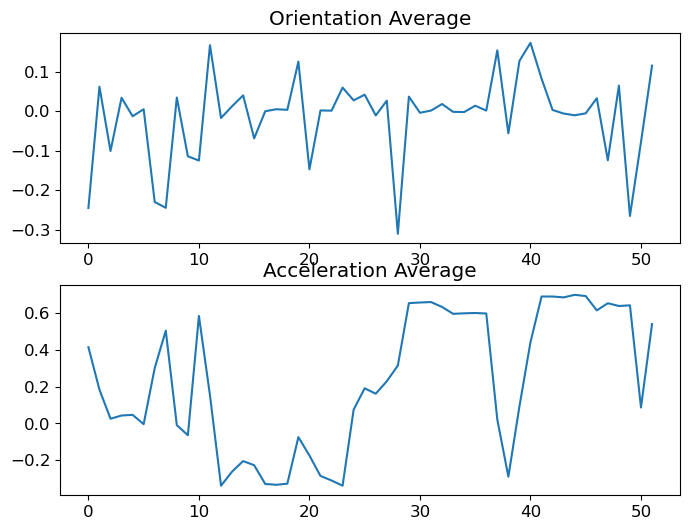

In [266]:
# Concatenate and inspect the data
data_processed = np.concatenate([data_average, data_std]).T #Missing the FFT components for now

fig2, axs = plt.subplots(2,1,figsize=(8,6))
axs[0].plot(data_processed[:,0])
axs[0].set_title('Orientation Average')
axs[1].plot(data_processed[:,4])
axs[1].set_title('Acceleration Average')
plt.show()

Then apply various clustering methods for comparison

In [267]:
cluster_range = range(8, 9)
kmeans_scores = []
agglo_scores = []
birch_scores = []
for num_cluster in cluster_range:

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=num_cluster)
    kmeans_labels = kmeans.fit_predict(data_processed)
    #print(f'kmeans labels: {kmeans_labels}')

    # Apply Agglomerative clustering
    agglomerative = AgglomerativeClustering(n_clusters=num_cluster)
    agglomerative_labels = agglomerative.fit_predict(data_processed)
    #print(f'agglomerative labels: {agglomerative_labels}')

    # Apply DBSCAN clustering
    #dbscan = DBSCAN(eps=0.5, min_samples=5)
    #dbscan_labels = dbscan.fit_predict(data_processed)
    #print(f'dbscan labels: {dbscan_labels}')

    # Apply MeanShift clustering
    #meanshift = MeanShift()
    #meanshift_labels = meanshift.fit_predict(data_processed)
    #print(f'meanshift labels: {meanshift_labels}')

    # Apply Spectral clustering
    spectral = SpectralClustering(n_clusters=num_cluster)
    spectral_labels = spectral.fit_predict(data_processed)
    #print(f'spectral labels: {spectral_labels}')

    # Apply Affinity 


    # Apply Birch clustering
    birch = Birch(n_clusters=num_cluster)
    birch_labels = birch.fit_predict(data_processed)
    #print(f'birch labels: {birch_labels}')

    # Apply OPTICS clustering
    #optics = OPTICS(min_samples=num_cluster)
    #optics_labels = optics.fit_predict(data_processed)
    #print(f'optics labels: {optics_labels}')

    #Scoring
    kmeans_scores.append(silhouette_score(data_processed, kmeans_labels))
    agglo_scores.append(silhouette_score(data_processed, agglomerative_labels))
    birch_scores.append(silhouette_score(data_processed, birch_labels))

optimal_kmeans = cluster_range[kmeans_scores.index(max(kmeans_scores))]
optimal_agglo = cluster_range[agglo_scores.index(max(agglo_scores))]
optimal_birch = cluster_range[birch_scores.index(max(birch_scores))]




c:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\micha\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\micha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.w

Optimal number of clusters (K-means): 8
Optimal number of clusters (Agglomerative Clustering): 8
Optimal number of clusters (Birch): 8


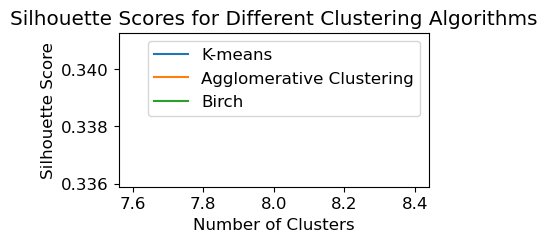

In [268]:
# Print the optimal number of clusters for each algorithm
print("Optimal number of clusters (K-means):", optimal_kmeans)
print("Optimal number of clusters (Agglomerative Clustering):", optimal_agglo)
print("Optimal number of clusters (Birch):", optimal_birch)

figx, axx = plt.subplots(figsize=(4,2))
plt.plot(cluster_range, kmeans_scores, label='K-means')
plt.plot(cluster_range, agglo_scores, label='Agglomerative Clustering')
plt.plot(cluster_range, birch_scores, label='Birch')

# Set plot labels and title
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Clustering Algorithms')
plt.legend()

# Show the plot
plt.show()


For visualizing I extract the labels and apply them to the tango_pos and then plot them accordingly (Only x and y dimensions)

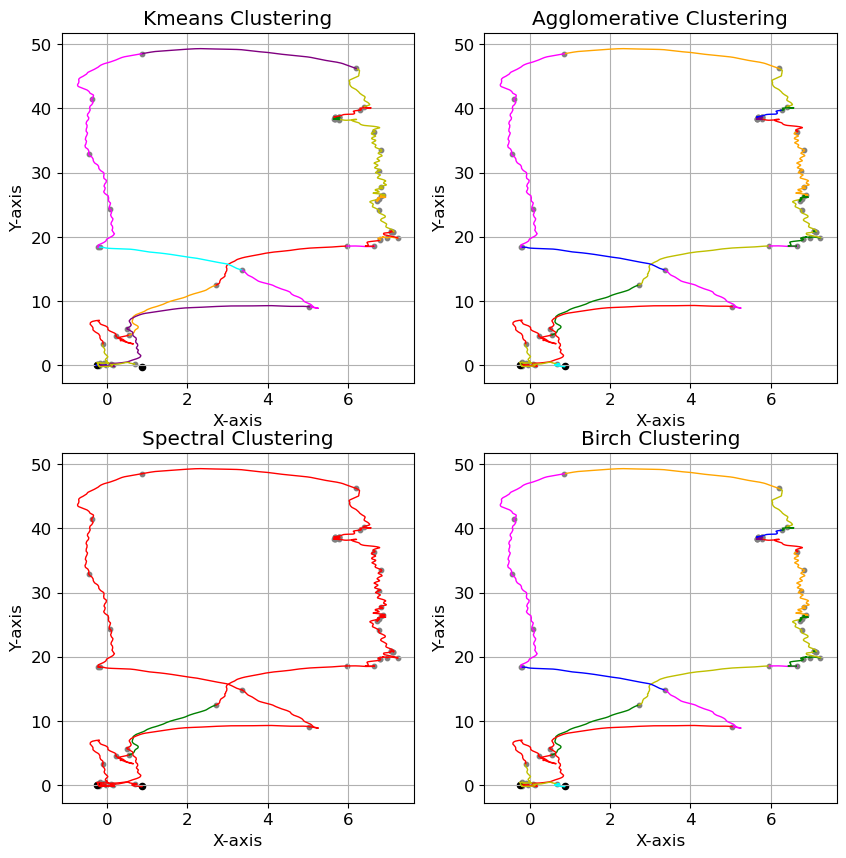

In [269]:
# Create a 2D line plot
color_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'magenta', 5: 'cyan', 6: 'orange', 7: 'purple', 8: 'brown'}


fig3, axs = plt.subplots(2,2, figsize=(10, 10))

for i in range(num_bins-1):
    axs[0,0].plot(tango_pos[i*time_bin_size:(i+1)*time_bin_size,0], tango_pos[i*time_bin_size:(i+1)*time_bin_size,1], color=color_map[kmeans_labels[i]], linewidth=1, linestyle='-')
    axs[0,0].scatter(tango_pos[(i+1)*time_bin_size,0], tango_pos[(i+1)*time_bin_size,1], color='grey', s=10)
axs[0,0].scatter(tango_pos[0,0],tango_pos[0,1],color='black', s=20)
axs[0,0].scatter(tango_pos[-1,0],tango_pos[-1,1],color='black', s=20)

# Set labels and title
axs[0,0].set_xlabel('X-axis')
axs[0,0].set_ylabel('Y-axis')
axs[0,0].set_title('Kmeans Clustering')
axs[0,0].grid(True)  # Add gridlines

for i in range(1, num_bins):
    axs[0,1].plot(tango_pos[i*time_bin_size:(i+1)*time_bin_size,0], tango_pos[i*time_bin_size:(i+1)*time_bin_size,1], color=color_map[agglomerative_labels[i]], linewidth=1, linestyle='-')
    axs[0,1].scatter(tango_pos[i*time_bin_size,0], tango_pos[i*time_bin_size,1], color='grey', s=10)
axs[0,1].scatter(tango_pos[0,0],tango_pos[0,1],color='black', s=20)
axs[0,1].scatter(tango_pos[-1,0],tango_pos[-1,1],color='black', s=20)

# Set labels and title
axs[0,1].set_xlabel('X-axis')
axs[0,1].set_ylabel('Y-axis')
axs[0,1].set_title('Agglomerative Clustering')
axs[0,1].grid(True)  # Add gridlines

for i in range(1, num_bins):
    axs[1,0].plot(tango_pos[i*time_bin_size:(i+1)*time_bin_size,0], tango_pos[i*time_bin_size:(i+1)*time_bin_size,1], color=color_map[spectral_labels[i]], linewidth=1, linestyle='-')
    axs[1,0].scatter(tango_pos[i*time_bin_size,0], tango_pos[i*time_bin_size,1], color='grey', s=10)
axs[1,0].scatter(tango_pos[0,0],tango_pos[0,1],color='black', s=20)
axs[1,0].scatter(tango_pos[-1,0],tango_pos[-1,1],color='black', s=20)

# Set labels and title
axs[1,0].set_xlabel('X-axis')
axs[1,0].set_ylabel('Y-axis')
axs[1,0].set_title('Spectral Clustering')
axs[1,0].grid(True)  # Add gridlines

for i in range(1, num_bins):
    axs[1,1].plot(tango_pos[i*time_bin_size:(i+1)*time_bin_size,0], tango_pos[i*time_bin_size:(i+1)*time_bin_size,1], color=color_map[birch_labels[i]], linewidth=1, linestyle='-')
    axs[1,1].scatter(tango_pos[i*time_bin_size,0], tango_pos[i*time_bin_size,1], color='grey', s=10)
axs[1,1].scatter(tango_pos[0,0],tango_pos[0,1],color='black', s=20)
axs[1,1].scatter(tango_pos[-1,0],tango_pos[-1,1],color='black', s=20)

# Set labels and title
axs[1,1].set_xlabel('X-axis')
axs[1,1].set_ylabel('Y-axis')
axs[1,1].set_title('Birch Clustering')
axs[1,1].grid(True)  # Add gridlines
plt.savefig(str(name)+'.png', dpi=300)
# Show the plot
plt.show()



Now for exporting the data

[ 0.59314853  0.44525249  0.51081206 -0.43473627]
[-2.59564511 -1.45334153  0.80001686]
0.615656420132148 0.40395946765127
0.459739517960073 0.6129686013680883
0.4758669658833839 0.5225455357860707
0.4971849700868397 0.553445763643474
0.47828044448083074 0.5485399157432139
0.5415142362047317 0.47011890519491195
0.43416072143547085 -0.5395324373198375
0.4407540773219477 0.5375851095058457
0.47094079278198636 0.5147165841708694
0.01772224285850897 -0.6619563298156642
0.4756239716175193 -0.5047796655580631
0.1502558360930325 0.6730813667422588
0.11110970763725203 0.6860238496815582
0.13800103253110474 0.6725883904303575
0.3064289510140561 0.6273934776923352
0.0829967780735845 0.690795608542308
0.07741995938291628 0.6891377010820898
0.10754806425897327 0.686749052264503
0.11467405302709664 0.6862715200645045
0.570725672337965 0.4413239630494702
0.0869000390136879 0.673513664250411
0.028770785308409645 0.6702602917103669
0.05874995471089694 0.6787677441282864
0.3551826759785671 0.5973498729

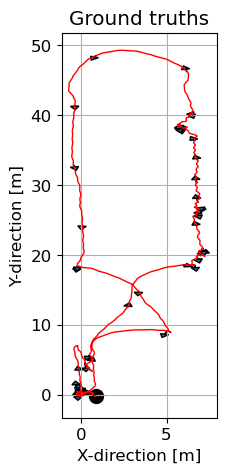

In [317]:
from scipy.spatial.transform import Rotation as R
import numpy as np

print(tango_ori[1000,:])
print(R.from_quat(tango_ori[1000,]).as_euler('xyz', degrees=False))
                    
fog12 ,ax12 = plt.subplots(figsize=(2,5))
"""
for i in range(num_bins-1):
    ax12.plot(tango_pos[i*time_bin_size:(i+1)*time_bin_size,0], tango_pos[i*time_bin_size:(i+1)*time_bin_size,1], color=color_map[kmeans_labels[i]], linewidth=1, linestyle='-')
    ax12.scatter(tango_pos[(i+1)*time_bin_size,0], tango_pos[(i+1)*time_bin_size,1], color='grey', s=10)
ax12.scatter(tango_pos[0,0],tango_pos[0,1],color='grey', s=20,label='Segment splits')
ax12.scatter(tango_pos[-1,0],tango_pos[-1,1],color='black', s=100,label='Start/End')
"""
ax12.plot(tango_pos[:,0], tango_pos[:,1], color='red',label='True position', linewidth=1, linestyle='-')
for i in range(num_bins-1): 
    #ax12.scatter(tango_pos[(i+1)*time_bin_size,0], tango_pos[(i+1)*time_bin_size,1], color='black', s=10)
    euler1 = R.from_quat(tango_ori[(i+1)*time_bin_size,:]).as_euler('xyz', degrees=False)[0]
    euler2 = R.from_quat(tango_ori[(i+1)*time_bin_size,:]).as_euler('xyz', degrees=False)[1]
    euler3 = R.from_quat(tango_ori[(i+1)*time_bin_size,:]).as_euler('xyz', degrees=False)[2]
    ax12.arrow(tango_pos[(i+1)*time_bin_size,0], tango_pos[(i+1)*time_bin_size,1], np.cos(euler1)*np.cos(euler2), -np.cos(euler2)*np.sin(euler1)+np.sin(euler3)*np.sin(euler2)*np.cos(euler1), head_width=0.5, head_length=0.5)
    print(tango_ori[(i+1)*time_bin_size,0], tango_ori[(i+1)*time_bin_size,1])
ax12.arrow(0,0,0,0,label='Orientation',color='black',head_width=1, head_length=1)
# Set labels and title
#ax12.scatter(tango_pos[0,0],tango_pos[0,1],color='black', s=20,label='Splits')
ax12.scatter(tango_pos[-1,0],tango_pos[-1,1],color='black', s=100,label='Start/End')
ax12.set_xlabel('X-direction [m]')
ax12.set_ylabel('Y-direction [m]')
ax12.set_title('Ground truths')
#ax12.legend()
ax12.grid(True)  # Add gridlines

In [271]:
kmeans_labels_fullsize = np.repeat(kmeans_labels,time_bin_size)
agglo_labels_fullsize = np.repeat(agglomerative_labels,time_bin_size)
birch_labels_fullsize = np.repeat(birch_labels,time_bin_size)

kmeans_labels_fullsize = np.append(kmeans_labels_fullsize,np.zeros(size%time_bin_size))
agglo_labels_fullsize = np.append(agglo_labels_fullsize,np.zeros(size%time_bin_size))
birch_labels_fullsize = np.append(birch_labels_fullsize,np.zeros(size%time_bin_size))

# Compute UMAP embedding
"""
# Plot UMAP with colored points based on cluster labels
for i in np.arange(0.1,1.0,0.1):
    embedding = umap.UMAP(n_neighbors=4, min_dist=i, metric='euclidean').fit_transform(data_processed)
    print(i)
    fig11, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(4, 10))
    ax1.scatter(embedding[:, 0], embedding[:, 1], c=kmeans_labels, cmap='viridis')
    ax1.set_title('UMAP with Kmeans Clustering')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.scatter(embedding[:, 0], embedding[:, 1], c=agglomerative_labels, cmap='viridis')
    ax2.set_title('UMAP with Agglomerative Clustering')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.scatter(embedding[:, 0], embedding[:, 1], c=birch_labels, cmap='viridis')
    ax3.set_title('UMAP with Birch Clustering')
    ax3.set_xticks([])
    ax3.set_yticks([])
    plt.show()
"""
# Remove y-axis ticks and labels
#ax1.set_colorbar()

combined_array = np.column_stack((kmeans_labels_fullsize, agglo_labels_fullsize, birch_labels_fullsize))

# Convert the combined array to a pandas DataFrame
df = pd.DataFrame(combined_array, columns=['kmeans_labels', 'agglo_labels', 'birch_labels'])

# Save the DataFrame as a .csv file with indexing included
df.to_csv(str(name)+'.csv', index=True)
